<a href="https://colab.research.google.com/github/IlyaTyagin/AGATHA-C-GP/blob/master/HW2/StationaryTS_IlyaTyagin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports we have already seen
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#new imports we will learn to use
import statsmodels.api as sm # for the statistical analysis to find out if the TS is stationary
import glob #to sort files
from pandas.plotting import scatter_matrix #will make useful correlatin plots
import json #reads and writes json files, see programmatic data access notebooks
import os #this runs system level commands, see programmatic data access notebooks

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#some annoying wornings show up - suppress them with this
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")

# data ingestion

use kaggle economic data accessing it programmatically at
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#a.us.txt

Access it programmatically as was done for the TESLA data in https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab3ProgrammaticDataAccess/Kaggledata_load.ipynb

Save it in a directory called MLTSA22/HW2/data in your google drive 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets list -s "Huge Stock Market Dataset"

ref                                                       title                                           size  lastUpdated          downloadCount  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
borismarjanovic/price-volume-data-for-all-us-stocks-etfs  Huge Stock Market Dataset                      492MB  2017-11-16 14:53:29          84161  
cryptrader/huge-japanese-stock-market-dataset-all-in-one  Huge Japanese Stock Market Dataset All in One  218MB  2021-02-09 11:58:22             39  


In [ ]:
!kaggle datasets download borismarjanovic/price-volume-data-for-all-us-stocks-etfs -p /content/drive/MyDrive/Classes/22S-PHYS-667/HW2

 99% 489M/492M [00:05<00:00, 75.1MB/s]
100% 492M/492M [00:05<00:00, 94.6MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Classes/22S-PHYS-667/HW2/price-volume-data-for-all-us-stocks-etfs.zip -d /content/drive/MyDrive/Classes/22S-PHYS-667/HW2

In [ ]:
cd /content/drive/MyDrive/Classes/22S-PHYS-667/HW2

/content/drive/MyDrive/Classes/22S-PHYS-667/HW2


In [ ]:
#use glob.glob to list the files in Data/Stocks. 
#This command returns a list, turn it into an array with np.array(<list>)
#Sort the array (alphabetically) with np.sort
glob.glob("Data/Stocks/*.txt")[:3]


['Data/Stocks/stng.us.txt',
 'Data/Stocks/tbnk.us.txt',
 'Data/Stocks/svvc.us.txt']

# read in the first 10 files in Data/Stock (first in alphabetical order.)

each file can be read with ```pd.read_csv()```

merge each file so that you end up with a single dataframe (e.g. call it tss)

```df1 = pd.read_csv()```

```df2 = pd.read_csv()```

```newdf = df.merge(df2)```

you want to merge on the date: this means the resulting dataframe will have a row for each date that is available in both files and all the columns of the files you are merging. To achieve this pass the argument ```on="Date"``` to ```df.merge()```

I also recommand you turn the Date column into the dataframe index

```tss.set_index("Date", inplace=True)```

In [ ]:
#files paths are stored in the allfiles variable sorted alphabetically...
allfiles = sorted(glob.glob("Data/Stocks/*.txt"))[:10]

In [ ]:
# merged dataframes are stored into a single dataframe called tss. Inspect it as discussed

In [ ]:
tss = (
    pd.read_csv(allfiles[0])
      .set_index('Date')[['Close']]
      .rename(
          columns={'Close': allfiles[0].split('/')[-1][:-4]}
      )
    )

for fname in allfiles[1:]:
  tss = tss.merge(
      (
        pd.read_csv(fname)
          .set_index('Date')[['Close']]
          .rename(
              columns={'Close': fname.split('/')[-1][:-4]}
              )
          ), 
          on='Date'
  )

In [ ]:
tss.head()

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
Date,,,,,,,,,,
2015-11-11,36.901,17.779,24.50,33.38,22.56,43.524,20.75,4.7960,24.649,16.76
2015-11-12,36.734,17.206,25.00,33.23,22.50,43.044,19.17,4.8951,24.182,16.11
2015-11-13,36.030,17.581,25.26,32.19,22.68,42.603,17.50,4.6672,23.795,16.60
2015-11-16,36.577,18.242,25.02,32.94,22.58,41.994,15.58,4.8455,23.923,16.93
2015-11-17,37.607,18.197,24.62,32.86,22.52,41.473,12.59,4.9150,23.418,16.68


In [ ]:
tss.tail()

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
Date,,,,,,,,,,
2017-11-02,68.13,47.46,81.00,70.51,10.02,47.257,88.00,3.65,35.80,39.28
2017-11-03,68.37,47.12,80.99,70.23,10.08,47.346,80.40,3.60,36.43,37.82
2017-11-07,68.25,46.97,81.00,72.22,11.07,46.358,81.00,3.40,34.44,37.89
2017-11-09,67.47,43.33,81.00,70.19,10.88,45.670,84.05,3.50,35.62,43.20
2017-11-10,66.81,43.01,80.98,70.56,11.28,45.820,80.10,3.50,36.59,45.30


In [ ]:
tss.shape

(447, 10)

#  data inspection

plot each time series (ts)

In [ ]:
tss.iloc[0], tss.iloc[-1] 

(a.us       36.901
 aa.us      17.779
 aaap.us    24.500
 aaba.us    33.380
 aac.us     22.560
 aal.us     43.524
 aamc.us    20.750
 aame.us     4.796
 aan.us     24.649
 aaoi.us    16.760
 Name: 2015-11-11, dtype: float64, a.us       66.81
 aa.us      43.01
 aaap.us    80.98
 aaba.us    70.56
 aac.us     11.28
 aal.us     45.82
 aamc.us    80.10
 aame.us     3.50
 aan.us     36.59
 aaoi.us    45.30
 Name: 2017-11-10, dtype: float64)

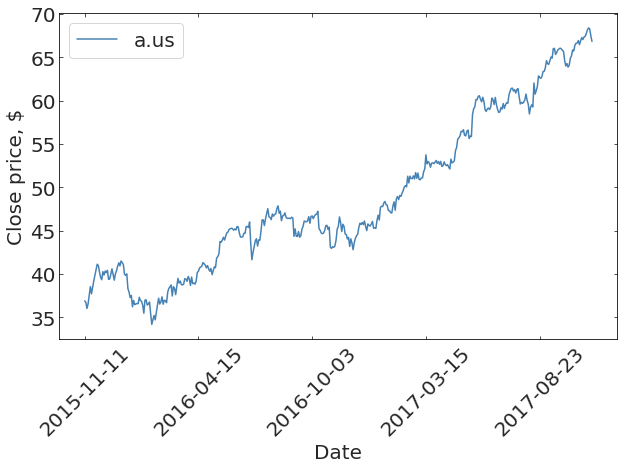

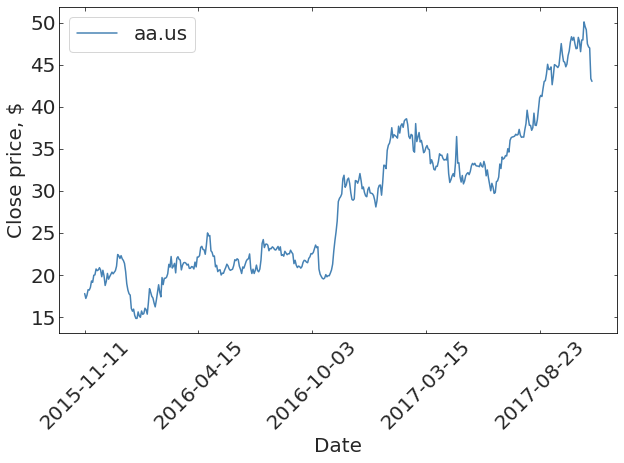

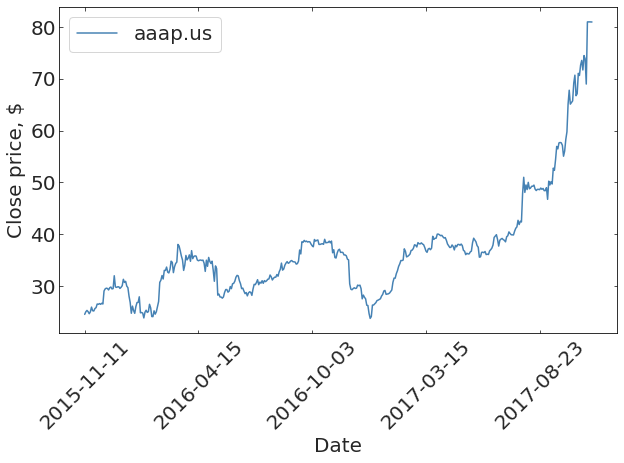

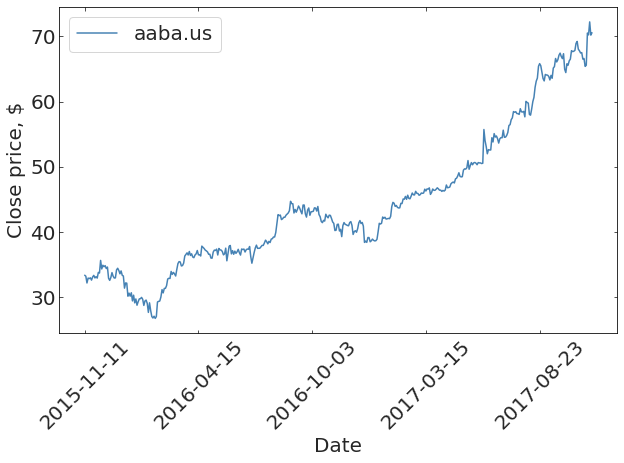

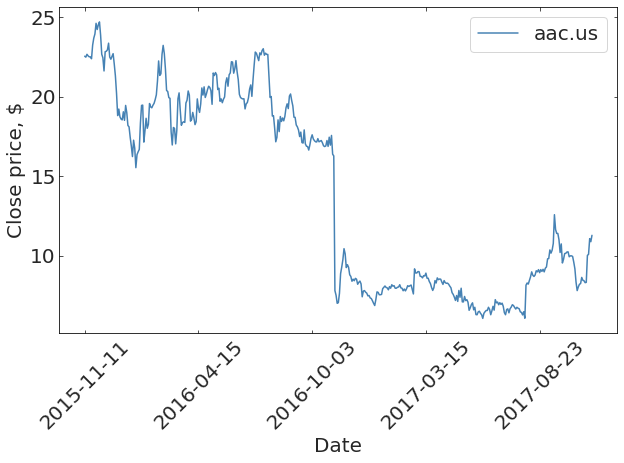

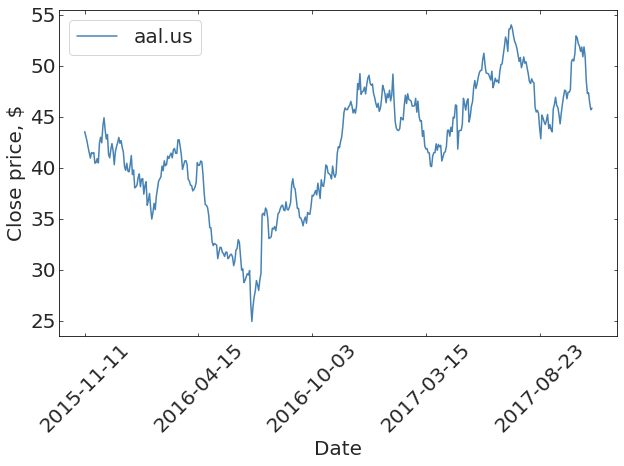

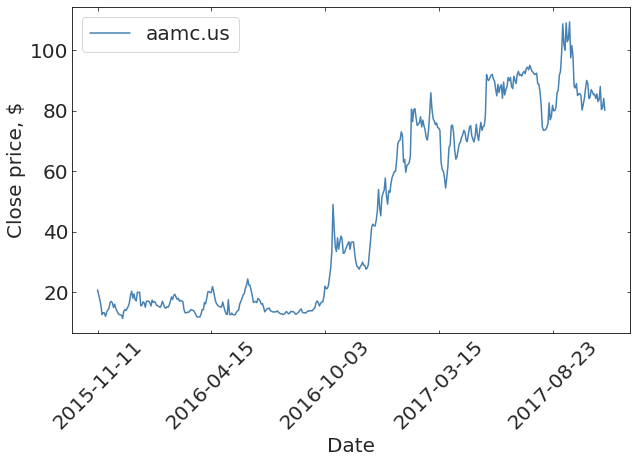

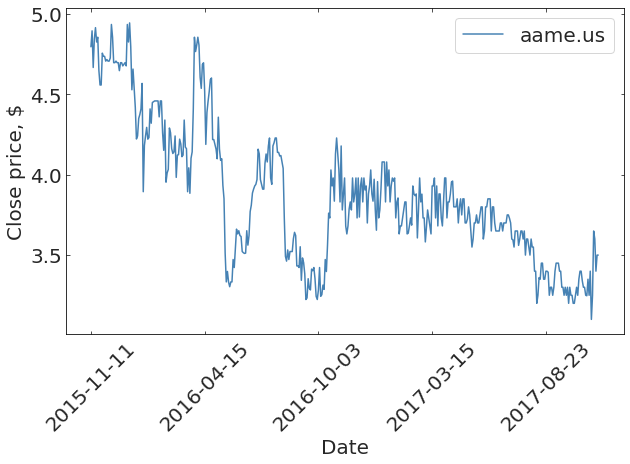

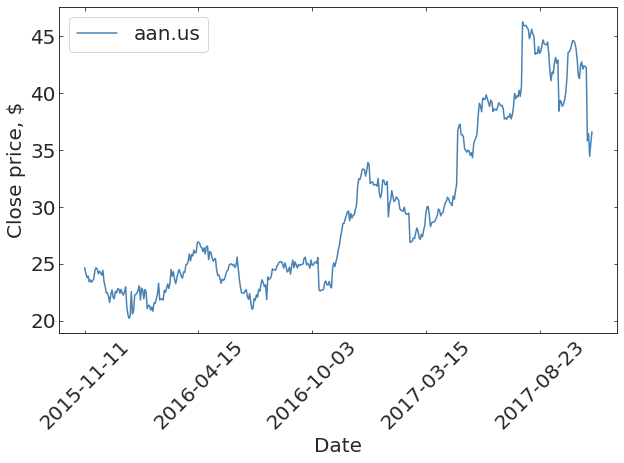

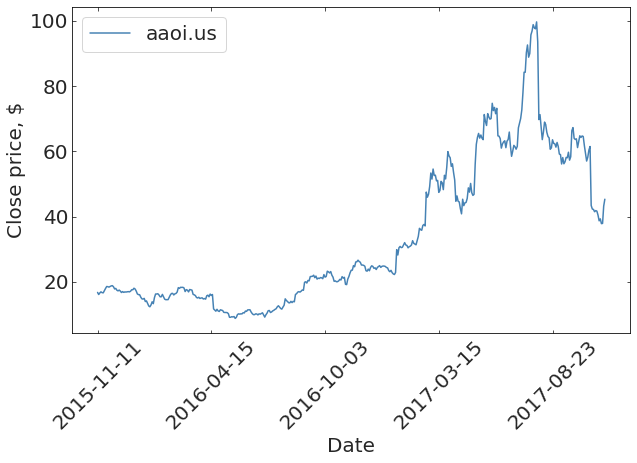

In [ ]:
# plot the 10 time series individually since they are only 10

for colname in tss.columns:
  tss[[colname]].plot(
      rot=45
  )
  plt.ylabel('Close price, $')
  plt.show()

Fig 1: Time series of Huge Stock Market Dataset close prices for $n=10$ ETFs. All of them show significant temporal dynamics.

## visualizing correlations

use ```pandas.plotting.scatter_matrix```  to look at the relationship between lightcurves

plot the pairwise correlation as a heatmap using ```pl.imshow()```. You can access the pairwise correlation with the dataframe method ```df.corr()```

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.
findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


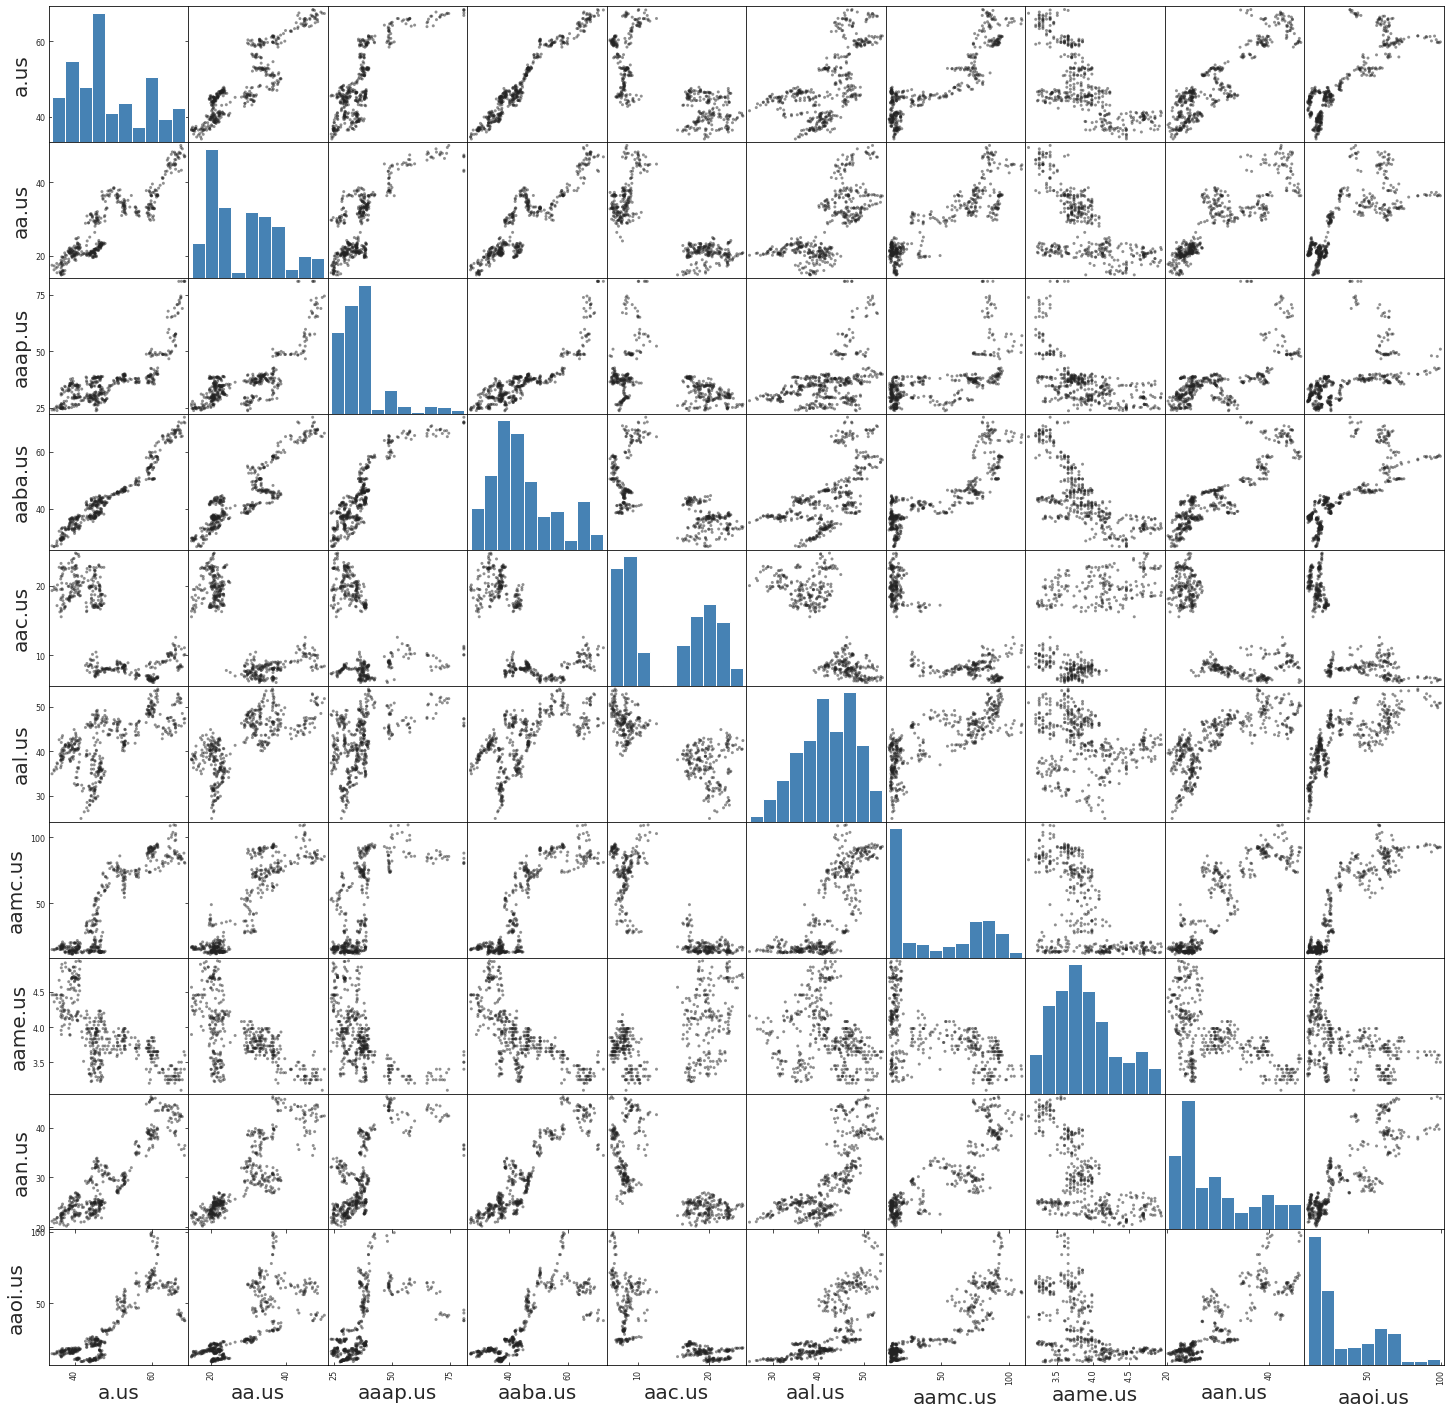

In [ ]:
scatter_matrix(tss, figsize=(25,25), color="#222222");

Fig 2: Pairwise correlation matrix. Diagonal shows distributions of numerical variables, whereas non-diag elements represent pairwise correlation plots.

In [ ]:
print("Correlation matrix of 2015-2017 stock values")
tss.corr()

Correlation matrix of 2015-2017 stock values


,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
a.us,1.000000,0.902139,0.800310,0.973457,-0.721867,0.621041,0.897263,-0.699609,0.905395,0.851239
aa.us,0.902139,1.000000,0.776600,0.904210,-0.791137,0.713229,0.893952,-0.606774,0.873520,0.766459
aaap.us,0.800310,0.776600,1.000000,0.872134,-0.423021,0.451520,0.621329,-0.573976,0.696179,0.560427
aaba.us,0.973457,0.904210,0.872134,1.000000,-0.670578,0.612989,0.849972,-0.709023,0.903785,0.809059
aac.us,-0.721867,-0.791137,-0.423021,-0.670578,1.000000,-0.785248,-0.868936,0.510986,-0.765267,-0.780147
aal.us,0.621041,0.713229,0.451520,0.612989,-0.785248,1.000000,0.780517,-0.219258,0.756808,0.746505
aamc.us,0.897263,0.893952,0.621329,0.849972,-0.868936,0.780517,1.000000,-0.544740,0.881631,0.904166
aame.us,-0.699609,-0.606774,-0.573976,-0.709023,0.510986,-0.219258,-0.544740,1.000000,-0.585002,-0.496371
aan.us,0.905395,0.873520,0.696179,0.903785,-0.765267,0.756808,0.881631,-0.585002,1.000000,0.860847
aaoi.us,0.851239,0.766459,0.560427,0.809059,-0.780147,0.746505,0.904166,-0.496371,0.860847,1.000000


findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


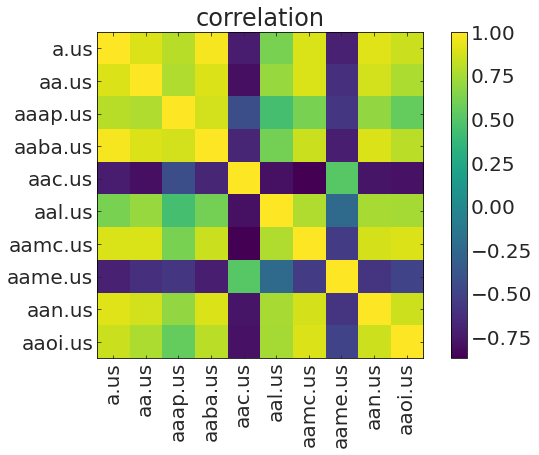

In [ ]:
# you can visualize it as a heat map with imshow
pl.imshow(tss.corr())
pl.colorbar()
pl.title("correlation")
pl.xticks(range(len(tss.columns)), tss.columns, rotation=90)
pl.yticks(range(len(tss.columns)), tss.columns);


Fig 3: Pairwise correlation heatmap of price changes over time. Yellow-ish colors represent positive dynamics, whereas blue-ish show negative.

## testing for stationarity
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

You will have to set a statistival threshold - choose 2-sigma. What fraction of a gaussian distribution is not contained inside of 2-sigma? this is the threshold you want to pass

In [ ]:
import statsmodels

In [ ]:
threshold = ...
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
...

Stationarity results from the AD Fuller test at a p-value of 0.05
Close is stationary: False
alim.us is stationary: True
...


In [17]:
# for 2-sigma error threshold is 0.05
threshold = 0.05

print ("Stationarity results from the AD Fuller test at a p-value of 0.05")

for c in tss.columns:
  adfuller_res = sm.tsa.stattools.adfuller(
      tss[c]
      )
  p_val = adfuller_res[1]
  print(f"{c} is stationary: {p_val < threshold}")

Stationarity results from the AD Fuller test at a p-value of 0.05
a.us is stationary: False
aa.us is stationary: False
aaap.us is stationary: False
aaba.us is stationary: False
aac.us is stationary: False
aal.us is stationary: False
aamc.us is stationary: False
aame.us is stationary: True
aan.us is stationary: False
aaoi.us is stationary: False
